In [1]:
import pymc3 as pm
import theano
import theano.tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
import exoplanet as xo
from exoplanet.distributions import Angle

import pymc3_ext as pmx
#from celerite2.theano import terms, GaussianProcess

import astropy.units as u
from astropy import constants
from astropy.time import Time


# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

deg = np.pi / 180.0
rad_2_deg = 180 / np.pi
yr = 365.25

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from sigfig import round

def get_median_sigma(pos):
    """
    Helper function to estimate median and sigma from posterior distribution
    Args:
        pos: array from posterior distribution
    Returns:
        (median,sigma): best fit value and 1 sigma uncertainty
    """
    temp = np.percentile(pos,[16,50,84])
    lower = temp[1]-temp[0]
    upper = temp[2]-temp[1]
    sigma = np.max([lower,upper])
    
    return (temp[1], sigma)

In [3]:
def xy_to_V2(f, x ,y , wv, u, v):
    """
    Helper function to estimate V2 model
    Args:
        f: flux ratio
        x: delta-RA in arcsec
        y: delta-DEC in arcsec
        wv: wavelenght (um)
        u,v: U/V projected baseline in meters
    Returns:
        model_v2: V^2 binary model
    """
    # constant : take into account astrometry in arcsec to radian & wave leght in micro meter 
    c =   np.pi/180/3600.*1e6
    # Model V^2 for unresolved components in a binary system (J.P. Berger and Damien Segransan 2007)
    model_v2 = ( 1 + f**2 + 2 * f * np.cos( 2 * np.pi * c * (u * x + v * y) / wv) ) / (1 + f)**2
    
    return model_v2
    

In [4]:
# # Keck Interferometer V2 data from  Boden et al. 2005

d = {'vis2': [0.606, 0.450, 0.464, 0.455, 0.349, 0.330, 0.205, 0.213, 0.158, 0.156, 0.131, 0.149],
     'vis2_err': [0.110, 0.132, 0.042, 0.030, 0.026, 0.028, 0.019, 0.013, 0.027, 0.020, 0.018, 0.013],
     'u': [56.149, 56.093, 55.452, 55.317, 54.458, 54.333, 51.467, 51.267, 47.550, 47.292, 44.576, 43.519],
     'v': [54.824, 54.631, 52.975, 52.699, 51.227, 51.042, 47.784, 47.602, 44.771, 44.604, 43.013, 42.462],
     'MJD': [53101.3170, 53101.3180, 53101.3290, 53101.3310, 53101.3410, 53101.3420, 53101.3660, 53101.3670,
             53101.3890, 53101.3900, 53101.4030, 53101.4080],
    'wv':[2.147,2.147,2.147,2.147,2.147,2.147,2.147,2.147,2.147,2.147,2.147,2.147]}
df_vis2_6Abril2004 = pd.DataFrame(data=d)


d = {'vis2': [0.263, 0.243, 0.241, 0.324, 0.198, 0.187, 0.173],
     'vis2_err': [0.067, 0.052, 0.061, 0.063, 0.026, 0.035, 0.042],
     'u': [53.160, 52.912, 50.225, 49.885, 40.756, 40.151, 39.385],
     'v': [49.530, 49.249, 49.716, 46.445, 41.170, 40.910, 40.592],
     'MJD': [53013.5930, 53013.5950, 53013.6140, 53013.6160, 53013.6600, 53013.6620, 53013.6650],
    'wv': [2.15, 2.15,2.15,2.15,2.15,2.15,2.15]}
df_vis2_9Jan2004 = pd.DataFrame(data=d)


d = {'vis2': [0.580, 0.512, 0.248, 0.246, 0.114, 0.109],
     'vis2_err': [0.125, 0.163, 0.026, 0.034, 0.019, 0.017],
     'u': [47.509, 47.193, 42.427, 42.108, 39.028, 38.548],
     'v': [44.738, 44.535, 41.919, 41.768, 40.434, 40.245],
     'MJD': [53482.3460, 53482.3480, 53482.3700, 53482.3710, 53482.3830, 53482.3850],
    'wv': [2.147, 2.147, 2.147, 2.147, 2.147, 2.147]}
df_vis2_22abril2005 = pd.DataFrame(data=d)


d = {'vis2': [0.218, 0.219, 0.220],
     'vis2_err': [0.049, 0.060, 0.033],
     'u': [43.882,43.444,43.105],
     'v': [42.652,42.428,42.259],
     'MJD': [52781.2830, 52781.2850, 52781.2860],
    'wv': [2.147, 2.147, 2.147]}
df_vis2_22May2003 = pd.DataFrame(data=d)


d = {'vis2': [0.604, 0.604, 0.598, 0.568, 0.549, 0.542],
     'vis2_err': [0.036, 0.070, 0.085, 0.063, 0.068, 0.027],
     'u': [49.874, 49.675, 46.649, 46.413, 43.934, 43.665],
     'v': [46.435, 46.280, 44.207, 44.063, 42.680, 42.541],
     'MJD': [52747.3450, 52747.3460, 52747.3630, 52747.3640, 52747.3750, 52747.3760],
    'wv': [2.15, 2.15, 2.15, 2.15, 2.15, 2.15]}
df_vis2_18abril2003 = pd.DataFrame(data=d)

# Keck Interferometer V2 data to numpy for fitting
u_data_a05 = df_vis2_22abril2005['u'].to_numpy()
v_data_a05 = df_vis2_22abril2005['v'].to_numpy()
wavel_a05 = np.median(df_vis2_22abril2005['wv'].to_numpy())
t_vis_a05 = np.median(df_vis2_22abril2005['MJD'].to_numpy()) + 2400000.5 # [Julian Date]
vis_err_a05 = df_vis2_22abril2005['vis2_err'].to_numpy()
vis2_a05 = df_vis2_22abril2005['vis2'].to_numpy() 

u_data_a04 = df_vis2_6Abril2004['u'].to_numpy()
v_data_a04 = df_vis2_6Abril2004['v'].to_numpy()
wavel_a04 = np.median(df_vis2_6Abril2004['wv'].to_numpy())
t_vis_a04 = np.median(df_vis2_6Abril2004['MJD'].to_numpy()) + 2400000.5 # [Julian Date]
vis_err_a04 = df_vis2_6Abril2004['vis2_err'].to_numpy()
vis2_a04 = df_vis2_6Abril2004['vis2'].to_numpy() 

u_data_j04 = df_vis2_9Jan2004['u'].to_numpy()
v_data_j04 = df_vis2_9Jan2004['v'].to_numpy()
wavel_j04 = np.median(df_vis2_9Jan2004['wv'].to_numpy())
t_vis_j04 = np.median(df_vis2_9Jan2004['MJD'].to_numpy()) + 2400000.5 # [Julian Date]
vis_err_j04 = df_vis2_9Jan2004['vis2_err'].to_numpy()
vis2_j04 = df_vis2_9Jan2004['vis2'].to_numpy() 

u_data_m03 = df_vis2_22May2003['u'].to_numpy()
v_data_m03 = df_vis2_22May2003['v'].to_numpy()
wavel_m03 = np.median(df_vis2_22May2003['wv'].to_numpy())
t_vis_m03 = np.median(df_vis2_22May2003['MJD'].to_numpy()) + 2400000.5 # [Julian Date]
vis_err_m03 = df_vis2_22May2003['vis2_err'].to_numpy()
vis2_m03 = df_vis2_22May2003['vis2'].to_numpy() 

u_data_a03 = df_vis2_18abril2003['u'].to_numpy()
v_data_a03 = df_vis2_18abril2003['v'].to_numpy()
wavel_a03 = np.median(df_vis2_18abril2003['wv'].to_numpy())
t_vis_a03 = np.median(df_vis2_18abril2003['MJD'].to_numpy()) + 2400000.5 # [Julian Date]
vis_err_a03 = df_vis2_18abril2003['vis2_err'].to_numpy()
vis2_a03 = df_vis2_18abril2003['vis2'].to_numpy() 

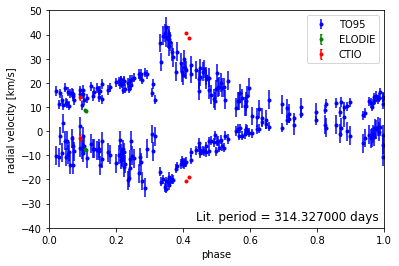

In [5]:
# Read RV data from Torres et al. 1995
RV_Ba = pd.read_csv('RV_Ba.csv')
RV_Bb = pd.read_csv('RV_Bb.csv')

t = RV_Ba['HJD'].to_numpy()
rva = RV_Ba['Ba'].to_numpy()
rva_err = RV_Ba['Ba_err'].to_numpy()

rvb = RV_Bb['Bb'].to_numpy()
rvb_err = RV_Bb['Bb_err'].to_numpy()

# Read RV data from ELODIE archive
RV_Ba = pd.read_csv('RV_Ba_ELODIE.csv') 
RV_Bb = pd.read_csv('RV_Bb_ELODIE.csv')

t_ELO = RV_Ba['MJD'].to_numpy()  + 2400000.5 # MJD to JD
rva_ELO = RV_Ba['Ba'].to_numpy()
rva_err_ELO = RV_Ba['Ba_err'].to_numpy()

rvb_ELO = RV_Bb['Bb'].to_numpy()
rvb_err_ELO = RV_Bb['Bb_err'].to_numpy()

# Read RV data from CTIO
RV_Ba = pd.read_csv('RV_Ba_CTIO.csv') 
RV_Bb = pd.read_csv('RV_Bb_CTIO.csv')

t_CTIO = RV_Ba['MJD'].to_numpy()  + 2400000.5 # MJD to JD
rva_CTIO = RV_Ba['Ba'].to_numpy()
rva_err_CTIO = RV_Ba['Ba_err'].to_numpy()

rvb_CTIO = RV_Bb['Bb'].to_numpy()
rvb_err_CTIO = RV_Bb['Bb_err'].to_numpy()


# Plot the observations "folded" on the published period:
# Boden et al. (2005) arXiv:astro-ph/0508331
lit_period = 314.327

# Primary
plt.errorbar(
    (t % lit_period) / lit_period, rva, yerr=rva_err, fmt=".b", capsize=0, label="TO95"
)

plt.errorbar(
    (t_ELO % lit_period) / lit_period, rva_ELO, yerr=rva_err_ELO, fmt=".g", capsize=1, label="ELODIE"
)

plt.errorbar(
    (t_CTIO % lit_period) / lit_period, rva_CTIO, yerr=rva_err_CTIO, fmt=".r", capsize=1, label="CTIO"
)

# Secondary
plt.errorbar(
    (t % lit_period) / lit_period, rvb, yerr=rvb_err, fmt=".b", capsize=0)

plt.errorbar(
    (t_ELO % lit_period) / lit_period, rvb_ELO, yerr=rvb_err_ELO, fmt=".g", capsize=1
)

plt.errorbar(
    (t_CTIO % lit_period) / lit_period, rvb_CTIO, yerr=rvb_err_CTIO, fmt=".r", capsize=1
)



plt.xlim(0, 1)
plt.ylim(-40, 50)
plt.annotate(
    "Lit. period = {0:.6f} days".format(lit_period),
    xy=(1, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10)

plt.ylabel("radial velocity [km/s]")
_ = plt.xlabel("phase")

In [6]:
#Define the model to fit SB2

with pm.Model() as model:

    # Parameters initial values from Torres et al. 1995
    logK1 = pm.Uniform(
        "logK1",
        lower=0,
        upper=np.log(50),
        testval=np.log(22.54),
    )
    
    logK2 = pm.Uniform(
        "logK2",
        lower=0,
        upper=np.log(50),
        testval=np.log(27.04),
    )
    
    logP = pm.Uniform(
        "logP", lower=np.log(300), upper=np.log(330), testval=np.log(lit_period)
    )
    
    P = pm.Deterministic("P", tt.exp(logP))
    #Primary
    K1 = pm.Deterministic("K1", tt.exp(logK1))
        
    # Secondary
    K2 = pm.Deterministic("K2", tt.exp(logK2))
   

    tp_0 = 48709.48 + 2400000.5 # [Julian Date]
    tp = pm.Normal("tp", mu=tp_0, sd=10, testval=tp_0)

    # Parameterize the eccentricity using:
    #  h = sqrt(e) * cos(w)
    #  k = sqrt(e) * sin(w)
    # testval from Torres et al. 1995 (e ~ 0.7812 and omega ~ 109.5 deg)
    hk = xo.UnitDisk("hk", testval=np.array([-0.29, 0.83]))
    #hk = xo.UnitDisk("hk", testval=np.array([0.29, -0.83]))
    ecc = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    omega = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))
    
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t_periastron=tp, ecc=ecc, omega=omega
    )
    
    # Torres et al. 1995
    gamma = pm.Normal("gamma", mu=0.0, sd=10.0, testval=5.73)
    # ELODIE
    gamma_ELO = pm.Normal("gamma_ELO", mu=0.0, sd=10.0, testval=5.73)
    
    # ELODIE
    gamma_CTIO = pm.Normal("gamma_CTIO", mu=0.0, sd=10.0, testval=0.0)
    
    # Instrumental jitter
    logjit_TO95 = pm.Uniform("logjitterTO95", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_ELODIE_A = pm.Uniform("logjitterELODIE_A", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_ELODIE_B = pm.Uniform("logjitterELODIE_B", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_CTIO_A = pm.Uniform("logjitterCTIO_A", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_CTIO_B = pm.Uniform("logjitterCTIO_B", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    
    jit_TO95 = pm.Deterministic("jitTO95", tt.exp(logjit_TO95))
    jit_ELODIE_A = pm.Deterministic("jitELODIE_A", tt.exp(logjit_ELODIE_A))
    jit_ELODIE_B = pm.Deterministic("jitELODIE_B", tt.exp(logjit_ELODIE_B))
    jit_CTIO_A = pm.Deterministic("jitCTIO_A", tt.exp(logjit_CTIO_A))
    jit_CTIO_B = pm.Deterministic("jitCTIO_B", tt.exp(logjit_CTIO_B))

    # Set up the radial velocity model
    def model_rv1(t,offset):
        return offset + orbit.get_radial_velocity(t,K=K1)
        
    def model_rv2(t,offset):
        return offset - orbit.get_radial_velocity(t,K=K2)
        
    #Primary
    rvmodel_a = pm.Deterministic("rvmodel_a", model_rv1(t,gamma))
    rvmodel_a_ELO = pm.Deterministic("rvmodel_a_ELO", model_rv1(t_ELO,gamma_ELO))
    rvmodel_a_CTIO = pm.Deterministic("rvmodel_a_CTIO", model_rv1(t_CTIO,gamma_CTIO))
        
    #Secondary
    rvmodel_b = pm.Deterministic("rvmodel_b", model_rv2(t,gamma))
    rvmodel_b_ELO = pm.Deterministic("rvmodel_b_ELO", model_rv2(t_ELO,gamma_ELO))
    rvmodel_b_CTIO = pm.Deterministic("rvmodel_b_CTIO", model_rv2(t_CTIO,gamma_CTIO))
        
    # get the total errors
    def get_err(rv_err, logjitter):
        return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))

    # Condition on the observations
    pm.Normal("obs_a", mu=rvmodel_a, sd=get_err(rva_err, logjit_TO95), observed=rva)
    pm.Normal("obs_b", mu=rvmodel_b, sd=get_err(rvb_err, logjit_TO95), observed=rvb)
    #ELODIE
    pm.Normal("obs_a_ELO", mu=rvmodel_a_ELO, sd=get_err(rva_err_ELO, logjit_ELODIE_A),
              observed=rva_ELO)
    pm.Normal("obs_b_ELO", mu=rvmodel_b_ELO, sd=get_err(rvb_err_ELO, logjit_ELODIE_B),
              observed=rvb_ELO)
    #CTIO
    pm.Normal("obs_a_CTIO", mu=rvmodel_a_CTIO, sd=get_err(rva_err_CTIO, logjit_CTIO_A),
              observed=rva_CTIO)
    pm.Normal("obs_b_CTIO", mu=rvmodel_b_CTIO, sd=get_err(rvb_err_CTIO, logjit_CTIO_B),
              observed=rvb_CTIO)

    # Optimize the logp
    map_soln = model.test_point
    #map_soln = pmx.optimize(map_soln, [gamma, gamma_2])
    map_soln = pmx.optimize(map_soln, [gamma, tp])
    map_soln = pmx.optimize(map_soln, [gamma, tp, logK1, logK2])
    map_soln = pmx.optimize(map_soln)

optimizing logp for variables: [tp, gamma]


message: Optimization terminated successfully.
logp: -1109.5750728640282 -> -1104.9129412127775
optimizing logp for variables: [logK2, logK1, tp, gamma]


message: Optimization terminated successfully.
logp: -1104.9129412127775 -> -1047.278357523562
optimizing logp for variables: [logjitterCTIO_B, logjitterCTIO_A, logjitterELODIE_B, logjitterELODIE_A, logjitterTO95, gamma_CTIO, gamma_ELO, gamma, hk, tp, logP, logK2, logK1]


message: Optimization terminated successfully.
logp: -1047.278357523562 -> -767.2007109494435


-11.587313214285977
-12.54455480030335


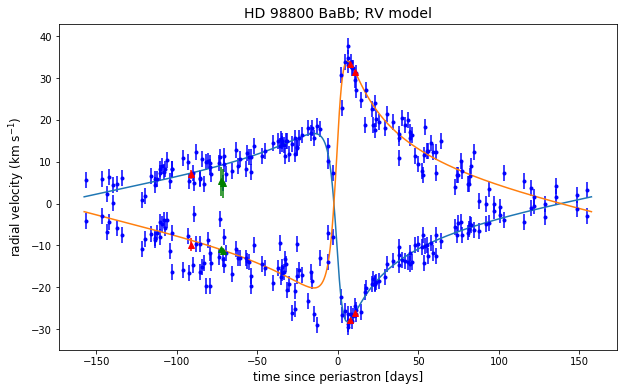

In [10]:
period = map_soln["P"]
tp = map_soln["tp"]
gamma = map_soln["gamma"]
gamma_ELO = map_soln["gamma_ELO"]
gamma_CTIO = map_soln["gamma_CTIO"]

ELO_errA = np.sqrt(rva_err_ELO**2 + np.exp(2 * np.median(map_soln["logjitterELODIE_A"])))
ELO_errB = np.sqrt(rvb_err_ELO**2 + np.exp(2 * np.median(map_soln["logjitterELODIE_B"])))
TO95_errA = np.sqrt(rva_err**2 + np.exp(2 * np.median(map_soln["logjitterTO95"])))
TO95_errB = np.sqrt(rvb_err**2 + np.exp(2 * np.median(map_soln["logjitterTO95"])))
CTIO_errA = np.sqrt(rva_err_CTIO**2 + np.exp(2 * np.median(map_soln["logjitterCTIO_A"])))
CTIO_errB = np.sqrt(rvb_err_CTIO**2 + np.exp(2 * np.median(map_soln["logjitterCTIO_B"])))


fig, axes = plt.subplots(figsize=(10, 6))

folded = ((t - tp + 0.5 * period) % period) - 0.5 * period

folded_ELO = ((t_ELO - tp + 0.5 * period) % period) - 0.5 * period

folded_CTIO = ((t_CTIO - tp + 0.5 * period) % period) - 0.5 * period

plt.errorbar(folded, rva-gamma, yerr=rva_err, fmt=".b")
plt.errorbar(folded, rvb-gamma, yerr=rva_err, fmt=".b")

plt.errorbar(folded_ELO, rva_ELO-gamma_ELO, yerr=ELO_errA, fmt="^g")
plt.errorbar(folded_ELO, rvb_ELO-gamma_ELO, yerr=ELO_errB, fmt="^g")

plt.errorbar(folded_CTIO, rva_CTIO-gamma_CTIO, yerr=CTIO_errA, fmt="^r")
plt.errorbar(folded_CTIO, rvb_CTIO-gamma_CTIO, yerr=CTIO_errB, fmt="^r")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)

with model:
    y1_mod, y2_mod = xo.eval_in_model(
        [model_rv1(x_phase + tp, gamma), model_rv2(x_phase + tp,gamma)],
        map_soln,
    )
    
with model:
    y1_test, y2_test = xo.eval_in_model(
        [model_rv2(54308.4955+2400000.5 ,0), model_rv2(54315.4672+2400000.5,0)],
        map_soln,
    )



plt.plot(x_phase, y1_mod-gamma, "C0")
plt.plot(x_phase, y2_mod-gamma, "C1")


#print(y1_test)
#print(y2_test)


plt.ylabel("radial velocity ($\mathrm{km~s^{-1}}$)", fontsize=12)
plt.xlabel("time since periastron [days]", fontsize=12)
_ = plt.title("HD 98800 BaBb; RV model", fontsize=14)

In [9]:
#That looks fine, so now we can run the MCMC sampler:
np.random.seed(39091)
with model:
    trace = pmx.sample(
        tune=3500, draws=3000, start=map_soln, chains=4, cores=4, target_accept=0.9, init="adapt_full",
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterCTIO_B, logjitterCTIO_A, logjitterELODIE_B, logjitterELODIE_A, logjitterTO95, gamma_CTIO, gamma_ELO, gamma, hk, tp, logP, logK2, logK1]


Sampling 4 chains for 3_500 tune and 3_000 draw iterations (14_000 + 12_000 draws total) took 236 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
# check convergence visually 
with model:
    _ = pm.traceplot(trace, var_names=["K1", "K2", "P", "tp", "e", "w"])

In [ ]:
with model:
    summary = pm.summary(
        trace,
        var_names=["K1", "K2", "P", "tp", "e", "w"],
        round_to=3
    )
summary

Period (days): 314.84$\pm$0.02
Tp (MJD): 48709.4$\pm$0.3
omega (deg): 109$\pm$1
e: 0.782$\pm$0.006
K1: 22.6$\pm$0.3
K2: 27.2$\pm$0.5
gamma: 5.7$\pm$0.1
gamma ELODIE: 3$\pm$4
gamma_CTIO: 7.0$\pm$0.4


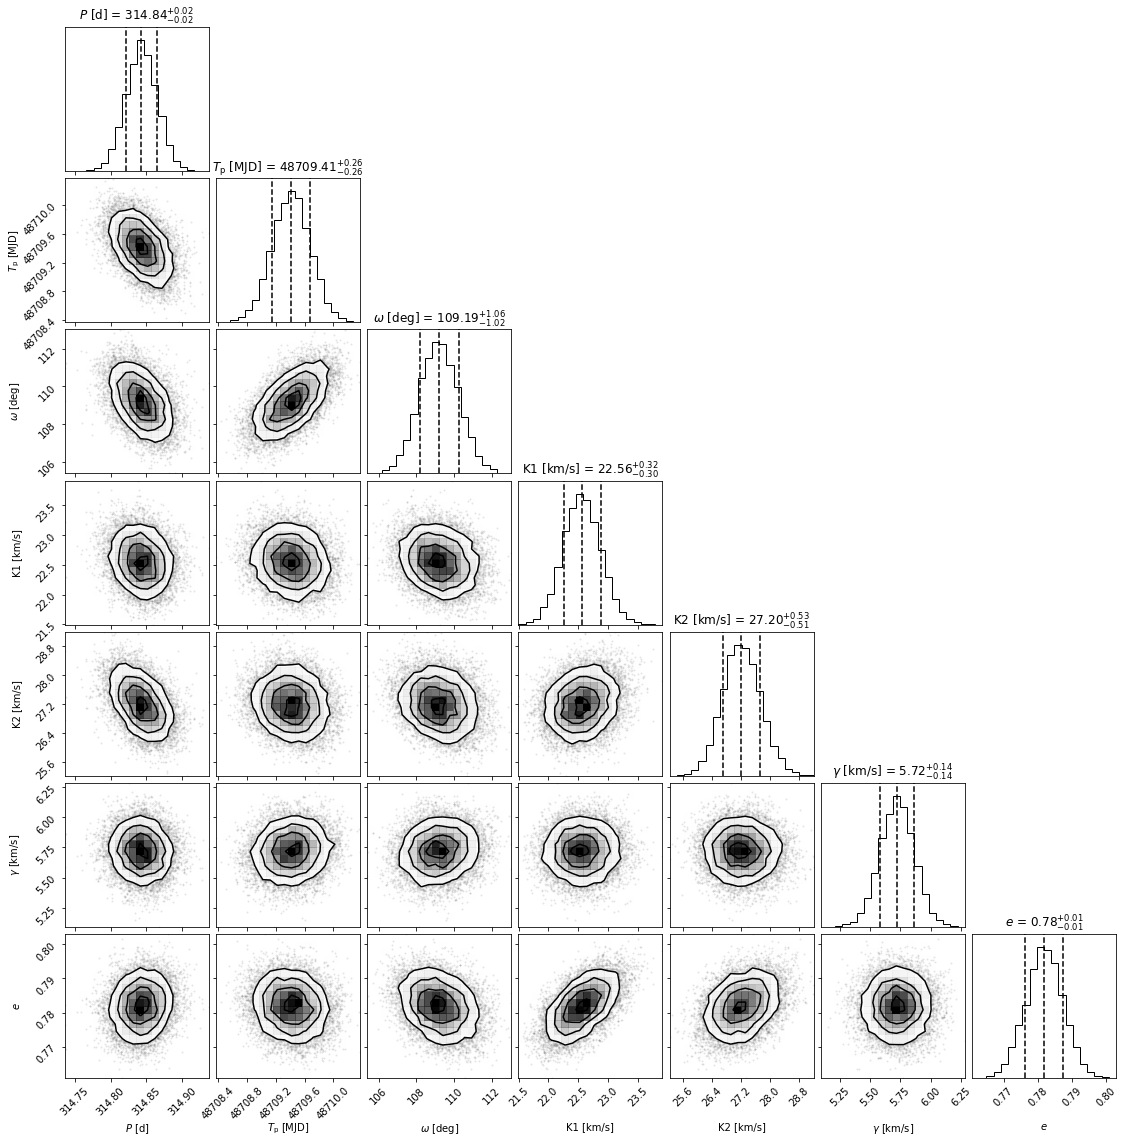

In [10]:
samples = pm.trace_to_dataframe(trace, varnames=["e"])
samples["$P$ [d]"] = trace["P"]
samples["$T_\mathrm{p}$ [MJD]"] = trace["tp"] - 2400000.5
samples["$\omega$ [deg]"] = (trace["w"] * rad_2_deg) % 360
samples["K1 [km/s]"] = (trace["K1"]) 
samples["K2 [km/s]"] = (trace["K2"])
samples["$\gamma$ [km/s]"] = (trace["gamma"])
#samples["$\gamma_2$ [km/s]"] = (trace["gamma_2"])
samples["$e$"] = samples["e"]


period, period_s = get_median_sigma(trace["P"])
print("Period (days): "+round(str(period), uncertainty=str(period_s), separation='$\pm$'))

tp, tp_s = get_median_sigma(trace["tp"]- 2400000.5)
print("Tp (MJD): "+round(str(tp), uncertainty=str(tp_s),separation='$\pm$'))

omega, omega_s = get_median_sigma((trace["w"] * rad_2_deg) % 360)
print("omega (deg): "+round(str(omega), uncertainty=str(omega_s), separation='$\pm$'))

ecc, ecc_s = get_median_sigma(trace["e"])
print("e: "+round(str(ecc), uncertainty=str(ecc_s), separation='$\pm$'))

K1, K1_s = get_median_sigma(trace["K1"])
print("K1: "+round(str(K1), uncertainty=str(K1_s), separation='$\pm$'))

K2, K2_s = get_median_sigma(trace["K2"])
print("K2: "+round(str(K2), uncertainty=str(K2_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma"])
print("gamma: "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))

gamma2, gamma2_s = get_median_sigma(trace["gamma_ELO"])
print("gamma ELODIE: "+round(str(gamma2), uncertainty=str(gamma2_s), separation='$\pm$'))

gamma2, gamma2_s = get_median_sigma(trace["gamma_CTIO"])
print("gamma_CTIO: "+round(str(gamma2), uncertainty=str(gamma2_s), separation='$\pm$'))

del samples["e"]
_ = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 12})

Error CTIO A:  [1.00161257 0.2079128  0.2079128 ]
Error CTIO B:  [1.50171939 0.50513476 0.50513476]
Error ELODIE A:  [3.04328043 3.04328043]
Error ELODIE B:  [0.45839971 0.45839971]


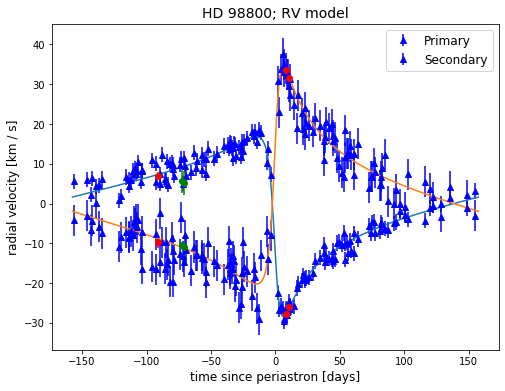

In [11]:
# Using the median value has a best solution
period_RV = np.percentile(trace["P"],[16,50,84],axis=0)
tp_RV = np.percentile(trace["tp"],[16,50,84],axis=0)
gamma_RV = np.percentile(trace["gamma"],[16,50,84],axis=0)
gamma_2 = np.percentile(trace["gamma_ELO"],[16,50,84],axis=0)
gamma_3 = np.percentile(trace["gamma_CTIO"],[16,50,84],axis=0)
omega_RV = np.percentile(trace["w"],[16,50,84],axis=0)
ecc_RV = np.percentile(trace["e"],[16,50,84],axis=0)
K1_RV = np.percentile(trace["K1"],[16,50,84],axis=0)
K2_RV = np.percentile(trace["K2"],[16,50,84],axis=0)

ELO_errA = np.sqrt(rva_err_ELO**2 + np.exp(2 * np.median(trace["logjitterELODIE_A"])))
ELO_errB = np.sqrt(rvb_err_ELO**2 + np.exp(2 * np.median(trace["logjitterELODIE_B"])))
TO95_errA = np.sqrt(rva_err**2 + np.exp(2 * np.median(trace["logjitterTO95"])))
TO95_errB = np.sqrt(rvb_err**2 + np.exp(2 * np.median(trace["logjitterTO95"])))
CTIO_errA = np.sqrt(rva_err_CTIO**2 + np.exp(2 * np.median(trace["logjitterCTIO_A"])))
CTIO_errB = np.sqrt(rvb_err_CTIO**2 + np.exp(2 * np.median(trace["logjitterCTIO_B"])))


fig, axes = plt.subplots(figsize=(8, 6))

folded = ((t - tp_RV[1]+ 0.5 * period_RV[1]) % period_RV[1]) - 0.5 * period_RV[1]
folded_ELO = ((t_ELO - tp_RV[1]+ 0.5 * period_RV[1]) % period_RV[1]) - 0.5 * period_RV[1]
folded_CTIO = ((t_CTIO - tp_RV[1]+ 0.5 * period_RV[1]) % period_RV[1]) - 0.5 * period_RV[1]

plt.errorbar(folded, rva-gamma_RV[1], yerr=TO95_errA, fmt="^b",label="Primary")
plt.errorbar(folded, rvb-gamma_RV[1], yerr=TO95_errB, fmt="^b",label="Secondary")

plt.errorbar(folded_ELO, rva_ELO-gamma_2[1], yerr=ELO_errA, fmt="og",)
plt.errorbar(folded_ELO, rvb_ELO-gamma_2[1], yerr=ELO_errB, fmt="og",)

plt.errorbar(folded_CTIO, rva_CTIO-gamma_3[1], yerr=CTIO_errA, fmt="or",)
plt.errorbar(folded_CTIO, rvb_CTIO-gamma_3[1], yerr=CTIO_errB, fmt="or",)

x_phase = np.linspace(-0.5 * period_RV[1], 0.5 * period_RV[1], 500)

with model:
    y1_mod, y2_mod = xo.eval_in_model(
        [model_rv1(x_phase + tp_RV[1], gamma_RV[1]), model_rv2(x_phase + tp_RV[1],gamma_RV[1])],
        map_soln,
    )

plt.plot(x_phase, y1_mod-gamma_RV[1], "C0")
plt.plot(x_phase, y2_mod-gamma_RV[1], "C1")

print('Error CTIO A: ',CTIO_errA)
print('Error CTIO B: ',CTIO_errB)
print('Error ELODIE A: ',ELO_errA)
print('Error ELODIE B: ',ELO_errB)


plt.legend(fontsize=12)
plt.ylabel("radial velocity [km / s]", fontsize=12)
plt.xlabel("time since periastron [days]", fontsize=12)
_ = plt.title("HD 98800; RV model", fontsize=14)

In [12]:
# Lets try now with a joint-fit (astrometry+RV)

# Read astrometry, we will use only the one from PIONIER
# for the case of KI observation we will fit directly the V^2 data
# so we skip the KI astrometry estimated from Boden
astrometry_elipse = pd.read_csv('HD98800B_astrometry.csv')
astrometry_elipse_B = astrometry_elipse.iloc[:2]


t_astro = astrometry_elipse_B['MJD'].to_numpy()
astro_jds = t_astro + 2400000.5 # [Julian Date]
y = astrometry_elipse_B['y'].to_numpy()
x = astrometry_elipse_B['x'].to_numpy()

# Semi major axis (sigma_maj) as a astrometry x,y error to be conservative (just for visualization).
x_err = astrometry_elipse_B['sigma_maj'].to_numpy()
y_err = astrometry_elipse_B['sigma_maj'].to_numpy()

# The uncertainties in the astrometry from optical interferomtry should be represented with an elipse error
# i.e PA, sigma_maj, sigma_min (see Gallenne et al. 2015). 
astro_sigma_maj = astrometry_elipse_B['sigma_maj'].to_numpy()
astro_sigma_min = astrometry_elipse_B['sigma_min'].to_numpy()
astrometry_PA = astrometry_elipse_B['PA'].to_numpy()

In [ ]:
%%script echo skipping

# Quick test to visualize the error elipse
from matplotlib.patches import Ellipse

th = np.linspace(0,2*np.pi,100)

angle = astrometry_PA[1]*deg

_x, _y = astro_sigma_maj[1]*np.cos(th), astro_sigma_min[1]*np.sin(th)
_x, _y = _x*np.cos(angle)+_y*np.sin(angle), -_y*np.cos(angle)+_x*np.sin(angle)
_x += x[1]
_y += y[1]

ellipse = Ellipse(xy=(x[1],y[1]),
                  width=astro_sigma_maj[1],
                  height=astro_sigma_min[1],
                  angle=astrometry_PA[1])

fig, ax = plt.subplots(nrows=1, figsize=(6, 6))

ax.add_artist(ellipse)
print(angle*rad_2_deg)

plt.plot(_x, _y, linestyle='-', color='r', linewidth=2)

plt.show()

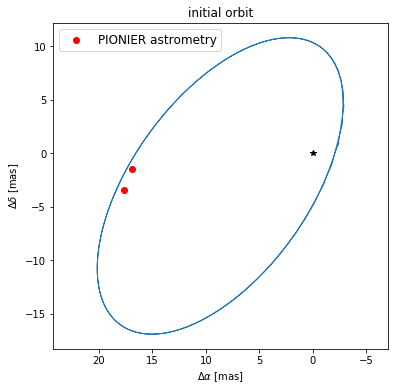

In [13]:
# Orbital elements from Boden et al. 2005
# For the relative astrometric fit, we only need the following parameters
a_ang_0 = 0.0233  # arcsec
parallax_0 = 0.0237  # arcsec 
a_0 = a_ang_0 * au_to_R_sun / parallax_0
e_0 = 0.7849
i_0 = 66.8 * deg  # [rad]
omega_0 = 289.6 * deg - np.pi  # omega_2, but we want omega_1
Omega_0 = 337.4 * deg
P_0 = 314.327   # days

#T0 = Time(1989.92, format="decimalyear")
#T0.format = "jd"
#T0 = T0.value  # [Julian Date]
T0 = 52481.34 + 2400000.5 # [Julian Date]


# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a_0, t_periastron=T0, period=P_0, incl=i_0, ecc=e_0, omega=omega_0, Omega=Omega_0
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t_fine = np.linspace(T0 - P_0, T0 + P_0, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t_fine, parallax_0))()

#y_model, x_model, z_model = theano.function([], orbit.get_relative_position(astro_jds, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(6, 6))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys*1000, xs*1000, color="C0", lw=1)


ax.scatter(x, y, marker="o", color ='r', label = 'PIONIER astrometry')
#ax.scatter(x_model*1000,y_model*1000)

ax.set_ylabel(r"$\Delta \delta$ [mas]")
ax.set_xlabel(r"$\Delta \alpha$ [mas]")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")
ax.legend(loc='upper left', prop={'size': 12})
#print(astrometry_PA[2])

plt.show()

In [14]:
# We use the Boden et al. 2005 plus RV results as a "first guess" for the joint fit solution 

# for predicted orbits
t_fine = np.linspace(tp_RV[1] - 500, tp_RV[1] + 500, num=1000)

# test P108 period 

t_enero = 2459594.62500 # 15 de Enero 2022 JD
t_febrero = 2459625.62500 # 15 de Febrero 2022 JD
t_marzo = 2459653.62500 # 15 de Marzo 2022 JD


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.001, 0.3, testval=a_ang_0)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 315 days,
        # so we'll set a broad prior on logP
        logP = pm.Uniform(
            "logP", lower=np.log(300), upper=np.log(330), testval=np.log(period_RV[1])
        )
        
        P = pm.Deterministic("P", tt.exp(logP))
        
        # Initial value from Boden et al. 2005
        Omega0 = Omega_0
        omega0 = omega_0
        
        omega = pm.Uniform("omega", lower=0*deg, upper=180*deg, testval=omega0)
        Omega = pm.Uniform("Omega", lower=0.0, upper=2*np.pi, testval=Omega0)
        
        ecc = pm.Uniform("ecc", lower=0.5, upper=0.99, testval=ecc_RV[1])
    
        tp = pm.Normal("tp", mu=tp_RV[1], sd=30, testval=tp_RV[1])

        # Geometric uniform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval= np.cos(i_0)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a= a * au_to_R_sun,
            t_periastron= tp,
            period= P,
            incl= incl,
            ecc= ecc,
            omega= omega,
            Omega= Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)
            
        #Primary
        K1 = pm.Uniform("K1", lower=0, upper=50, testval=K1_RV[1])
        
        # Secondary
        K2 = pm.Uniform("K2", lower=0, upper=50, testval=K2_RV[1])
        
        # The RV model
        gamma = pm.Uniform("gamma", lower=2, upper=8, testval=gamma_RV[1])
        # ELODIE
        gamma_ELO = pm.Uniform("gamma_ELO", lower=0, upper=20, testval=gamma_2[1])
        # CTIO
        gamma_CTIO = pm.Uniform("gamma_CTIO", lower=0, upper=20, testval=gamma_3[1])
        

        # Set up the radial velocity model
        def model_rv1(t,offset):
            return offset + orbit.get_radial_velocity(t,K=K1)
        
        def model_rv2(t,offset):
            return offset - orbit.get_radial_velocity(t,K=K2)
        
        #Primary
        rvmodel_a = pm.Deterministic("rvmodel_a", model_rv1(t,gamma))
        rvmodel_a_ELO = pm.Deterministic("rvmodel_a_ELO", model_rv1(t_ELO,gamma_ELO))
        rvmodel_a_CTIO = pm.Deterministic("rvmodel_a_CTIO", model_rv1(t_CTIO,gamma_CTIO))
        
        #Secondary
        rvmodel_b = pm.Deterministic("rvmodel_b", model_rv2(t,gamma))
        rvmodel_b_ELO = pm.Deterministic("rvmodel_b_ELO", model_rv2(t_ELO,gamma_ELO))
        rvmodel_b_CTIO = pm.Deterministic("rvmodel_b_CTIO", model_rv2(t_CTIO,gamma_CTIO))
        
        # get the total errors
        def get_err(rv_err, logjitter):
            return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))

        # Condition on the observations
        
        #TO95
        pm.Normal("obs_a", mu=rvmodel_a, sd=TO95_errA, observed=rva)
        pm.Normal("obs_b", mu=rvmodel_b, sd=TO95_errB, observed=rvb)
        #ELODIE
        pm.Normal("obs_a_ELO", mu=rvmodel_a_ELO, sd=ELO_errA, observed=rva_ELO)
        pm.Normal("obs_b_ELO", mu=rvmodel_b_ELO, sd=ELO_errB, observed=rvb_ELO)
        #Save O-C
        pm.Deterministic("OC_ELOa", (rva_ELO-rvmodel_a_ELO))
        pm.Deterministic("OC_ELOb", (rvb_ELO-rvmodel_b_ELO))
        #CTIO
        pm.Normal("obs_a_CTIO", mu=rvmodel_a_CTIO, sd=CTIO_errA, observed=rva_CTIO)
        pm.Normal("obs_b_CTIO", mu=rvmodel_b_CTIO, sd=CTIO_errB, observed=rvb_CTIO)
        #Save O-C
        pm.Deterministic("OC_CTIOa", (rva_CTIO-rvmodel_a_CTIO))
        pm.Deterministic("OC_CTIOb", (rvb_CTIO-rvmodel_b_CTIO))

        # Compute the model in x,y
        y_model, x_model, z_model = orbit.get_relative_position(astro_jds, plx)
        pm.Deterministic("x_model", x_model)
        pm.Deterministic("y_model", y_model)
        
        #Elipse error model
        # semi-major axis error
        Maj_err = (x_model - x/1000)*tt.cos(astrometry_PA*deg)+(y_model- y/1000)*tt.sin(astrometry_PA*deg)
        # semi-minor axis error
        Min_err = -(y_model-y/1000)*tt.cos(astrometry_PA*deg)+(x_model-x/1000)*tt.sin(astrometry_PA*deg)
        
        #pm.Deterministic('Maj_err', Maj_err)
        #pm.Deterministic('Min_err', Min_err)
        pm.Deterministic("x_err", (x/1000-x_model))
        pm.Deterministic("y_err", (y/1000-y_model))
        
        # define the likelihood function
        pm.Normal("sigmaMaj_obs", mu=Maj_err, sd=astro_sigma_maj/1000, observed=0.0)
        pm.Normal("sigmaMin_obs", mu=Min_err, sd=astro_sigma_min/1000, observed=0.0)
        
        
        # Set up predicted orbits for later plotting
        y_dense, x_dense, z_dense = orbit.get_relative_position(t_fine, plx)
        x_save = pm.Deterministic("x_save", x_dense)
        y_save = pm.Deterministic("y_save", y_dense)
        
        va_dense = orbit.get_radial_velocity(t_fine,K1)
        vb_dense = orbit.get_radial_velocity(t_fine,K2)
        
        va_save = pm.Deterministic("va_save",va_dense)
        vb_save = pm.Deterministic("vb_save",vb_dense)
        
        # Define flux ratio
        f = pm.Uniform("f", lower=0.1, upper=1, testval=0.6)
        
        y_v2model_a05, x_v2model_a05, z_model = orbit.get_relative_position(t_vis_a05, plx)
        pm.Deterministic("x_v2model_a05", x_v2model_a05)
        pm.Deterministic("y_v2model_a05", y_v2model_a05)
        
        y_v2model_a04, x_v2model_a04, z_model = orbit.get_relative_position(t_vis_a04, plx)
        pm.Deterministic("x_v2model_a04", x_v2model_a04)
        pm.Deterministic("y_v2model_a04", y_v2model_a04)
        
        y_v2model_a03, x_v2model_a03, z_model = orbit.get_relative_position(t_vis_a03, plx)
        pm.Deterministic("x_v2model_a03", x_v2model_a03)
        pm.Deterministic("y_v2model_a03", y_v2model_a03)
        
        y_v2model_m03, x_v2model_m03, z_model = orbit.get_relative_position(t_vis_m03, plx)
        pm.Deterministic("x_v2model_m03", x_v2model_m03)
        pm.Deterministic("y_v2model_m03", y_v2model_m03)
        
        y_v2model_j04, x_v2model_j04, z_model = orbit.get_relative_position(t_vis_j04, plx)
        pm.Deterministic("x_v2model_j04", x_v2model_j04)
        pm.Deterministic("y_v2model_j04", y_v2model_j04)
        
        # Model V^2 for unresolved components in a binary system (J.P. Berger and Damien Segransan 2007)
        # constant : take into account astrometry in arcsec to radian & wavelength in micro meter 
        c =   np.pi/180/3600.*1e6
        
        model_v2_a03 = ( 1 + f**2 + 2 * f * tt.cos( 2 * np.pi * c * (u_data_a03 * x_v2model_a03 + v_data_a03 * y_v2model_a03) / wavel_a03) ) / (1 + f)**2
        model_v2_a04 = ( 1 + f**2 + 2 * f * tt.cos( 2 * np.pi * c * (u_data_a04 * x_v2model_a04 + v_data_a04 * y_v2model_a04) / wavel_a04) ) / (1 + f)**2
        model_v2_a05 = ( 1 + f**2 + 2 * f * tt.cos( 2 * np.pi * c * (u_data_a05 * x_v2model_a05 + v_data_a05 * y_v2model_a05) / wavel_a05) ) / (1 + f)**2
        model_v2_m03 = ( 1 + f**2 + 2 * f * tt.cos( 2 * np.pi * c * (u_data_m03 * x_v2model_m03 + v_data_m03 * y_v2model_m03) / wavel_m03) ) / (1 + f)**2
        model_v2_j04 = ( 1 + f**2 + 2 * f * tt.cos( 2 * np.pi * c * (u_data_j04 * x_v2model_j04 + v_data_j04 * y_v2model_j04) / wavel_j04) ) / (1 + f)**2

        
        # define the likelihood function
        pm.Normal("v2_obs_a03", mu= model_v2_a03, sd=vis_err_a03, observed=vis2_a03)
        pm.Normal("v2_obs_a4", mu= model_v2_a04, sd=vis_err_a04, observed=vis2_a04)
        pm.Normal("v2_obs_a05", mu= model_v2_a05, sd=vis_err_a05, observed=vis2_a05)
        pm.Normal("v2_obs_m03", mu= model_v2_m03, sd=vis_err_m03, observed=vis2_m03)
        pm.Normal("v2_obs_j04", mu= model_v2_j04, sd=vis_err_j04, observed=vis2_j04)
        
        # Set up physical parameters from orbit (Torres et al. 2010, Gallenne et al. 2019)
        c1 = 1.036149E-7
        c2 = 9.191940E-5
        # Masses
        M1_save = pm.Deterministic("M1_save", 
                                   (c1 * (K1 + K2)**2 * K2 * P * (1- ecc**2)**(3.0/2) ) / (tt.sin(incl)**3))
        
        M2_save = pm.Deterministic("M2_save", 
                                   (c1 * (K1 + K2)**2 * K1 * P * (1- ecc**2)**(3.0/2) ) / (tt.sin(incl)**3))
        
        M_t = pm.Deterministic("Mt_save", M1_save + M2_save)
        
        # semi-major axis in AU
        a_AU = pm.Deterministic("a_AU", 
                                    (c2 * (K1 + K2) * P * (1 -ecc**2)**(1/2)) / tt.sin(incl))
        
        # Parallax (mas)
        plx_save = pm.Deterministic("plx_save", (a_ang/a_AU)*1000)
        
        # astrometry para P108
        y_enero, x_enero, z_model = orbit.get_relative_position(t_enero, plx)
        pm.Deterministic("x_enero", x_enero)
        pm.Deterministic("y_enero", y_enero)
        y_febrero, x_febrero, z_model = orbit.get_relative_position(t_febrero, plx)
        pm.Deterministic("x_febrero", x_febrero)
        pm.Deterministic("y_febrero", y_febrero)
        y_marzo, x_marzo, z_model = orbit.get_relative_position(t_marzo, plx)
        pm.Deterministic("x_marzo", x_marzo)
        pm.Deterministic("y_marzo", y_marzo)

        
        # Optimize to find the initial parameters
        # Optimize the logp
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln)


    return model, map_soln

model, map_soln = get_model() 


optimizing logp for variables: [f, gamma_CTIO, gamma_ELO, gamma, K2, K1, cos_incl, tp, ecc, Omega, omega, logP, a_ang]


message: Desired error not necessarily achieved due to precision loss.
logp: -31611.41093115918 -> -936.5854038740111


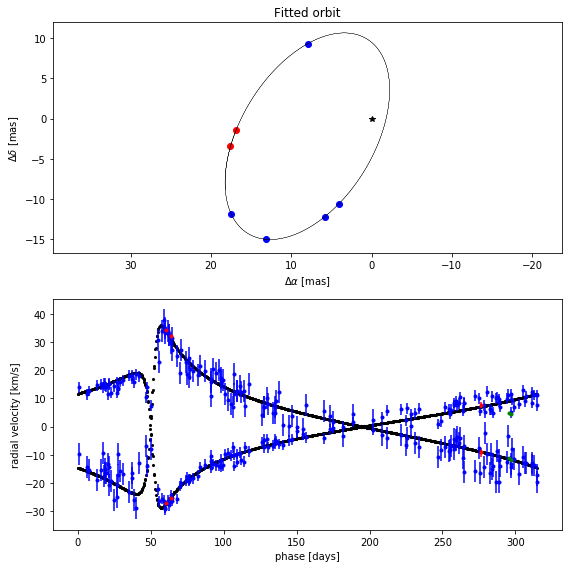

In [15]:
period = map_soln["P"]
gamma = map_soln["gamma"]
gamma2 = map_soln["gamma_ELO"]
gamma3 = map_soln["gamma_CTIO"]

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

ax = axes[0]

ax.set_ylabel(r"$\Delta \delta$ [mas]")
ax.scatter(x, y, marker='o', color='r')
ax.plot(map_soln["x_save"]*1000, map_soln["y_save"]*1000, color = "k", lw=0.2)

ax.scatter(map_soln["x_v2model_a03"]*1000, map_soln["y_v2model_a03"]*1000, color = "b",
           label='KI data phase coverage')
ax.scatter(map_soln["x_v2model_a04"]*1000, map_soln["y_v2model_a04"]*1000, color = "b")
ax.scatter(map_soln["x_v2model_a05"]*1000, map_soln["y_v2model_a05"]*1000, color = "b")
ax.scatter(map_soln["x_v2model_j04"]*1000, map_soln["y_v2model_j04"]*1000, color = "b")
ax.scatter(map_soln["x_v2model_m03"]*1000, map_soln["y_v2model_m03"]*1000, color = "b")

ax.set_xlabel(r"$\Delta \alpha$ [mas]")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("Fitted orbit")

ax = axes[1]
ax.errorbar(t % period, rva - gamma, yerr=rva_err, fmt=".b")
ax.errorbar(t % period, rvb - gamma, yerr=rvb_err, fmt=".b")
ax.errorbar(t_ELO % period, rva_ELO - gamma2, yerr=rva_err_ELO, fmt=".g")
ax.errorbar(t_ELO % period, rvb_ELO - gamma2, yerr=rvb_err_ELO, fmt=".g")
ax.errorbar(t_CTIO % period, rva_CTIO - gamma3, yerr=rva_err_CTIO, fmt=".r")
ax.errorbar(t_CTIO % period, rvb_CTIO - gamma3, yerr=rvb_err_CTIO, fmt=".r")

ax.scatter(t_fine % period, map_soln["va_save"], color = "k", marker='.',lw=0.1)
ax.scatter(t_fine % period, -map_soln["vb_save"], color = "k", marker='.',lw=0.1)

ax.set_ylabel("radial velocity [km/s]")
ax.set_xlabel("phase [days]")

#print(gamma3)
plt.tight_layout()

In [16]:
#That looks fine, so now we can run the MCMC sampler:
np.random.seed(39091)
with model:
    trace = pmx.sample(
        tune=7500, draws=4000, start=map_soln, chains=4, cores=4, target_accept=0.9, init="adapt_full",
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, gamma_CTIO, gamma_ELO, gamma, K2, K1, cos_incl, tp, ecc, Omega, omega, logP, a_ang]


Sampling 4 chains for 7_500 tune and 4_000 draw iterations (30_000 + 16_000 draws total) took 424 seconds.


In [17]:
# Then we can look the summary of the trace and the convergence the key parameters:
with model:
    summary = pm.summary(
        trace,
        var_names=["a_ang", "Omega", "omega", "incl", "tp", "P", "gamma", "plx_save", "K1", "K2"],
        round_to=3
    )

summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_ang,0.022,0.000,0.022,0.023,0.000,0.000,7904.649,7904.649,7889.503,7987.375,1.001
Omega,5.980,0.007,5.967,5.993,0.000,0.000,13132.193,13132.193,13139.568,11439.208,1.000
omega,1.824,0.006,1.813,1.835,0.000,0.000,7800.314,7797.345,7837.987,8531.391,1.001
incl,1.156,0.008,1.140,1.171,0.000,0.000,8101.341,8101.341,8118.755,7904.505,1.001
tp,2448708.020,0.210,2448707.632,2448708.420,0.001,0.001,24803.020,10598.922,18182.077,10805.386,1.000
P,314.858,0.017,314.827,314.889,0.000,0.000,18246.013,18246.013,18278.820,12021.139,1.000
gamma,5.604,0.141,5.340,5.870,0.001,0.001,19986.670,19931.425,19993.460,11469.805,1.000
plx_save,21.976,0.568,20.932,23.076,0.006,0.004,10477.570,10477.570,10468.696,9186.736,1.000
K1,24.015,0.325,23.417,24.633,0.003,0.002,12610.654,12610.654,12596.400,10828.249,1.000
K2,29.906,0.563,28.886,31.000,0.005,0.003,13844.629,13840.705,13885.416,10060.162,1.001


Period (days): 314.86$\pm$0.02
Tp (MJD): 48707.5$\pm$0.2
omega (deg): 104.5$\pm$0.3
Omega (deg): 342.6$\pm$0.4
i (deg): 66.2$\pm$0.5
a (mas): 22.2$\pm$0.4
e: 0.805$\pm$0.005
K1 (km/s): 24.0$\pm$0.3
K2 (km/s): 29.9$\pm$0.6
gamma TO95 (km/s): 5.6$\pm$0.1
gamma ELODIE (km/s): 3.9$\pm$0.4
gamma CTIO (km/s): 6.4$\pm$0.3
f2/f1 : 0.76$\pm$0.08


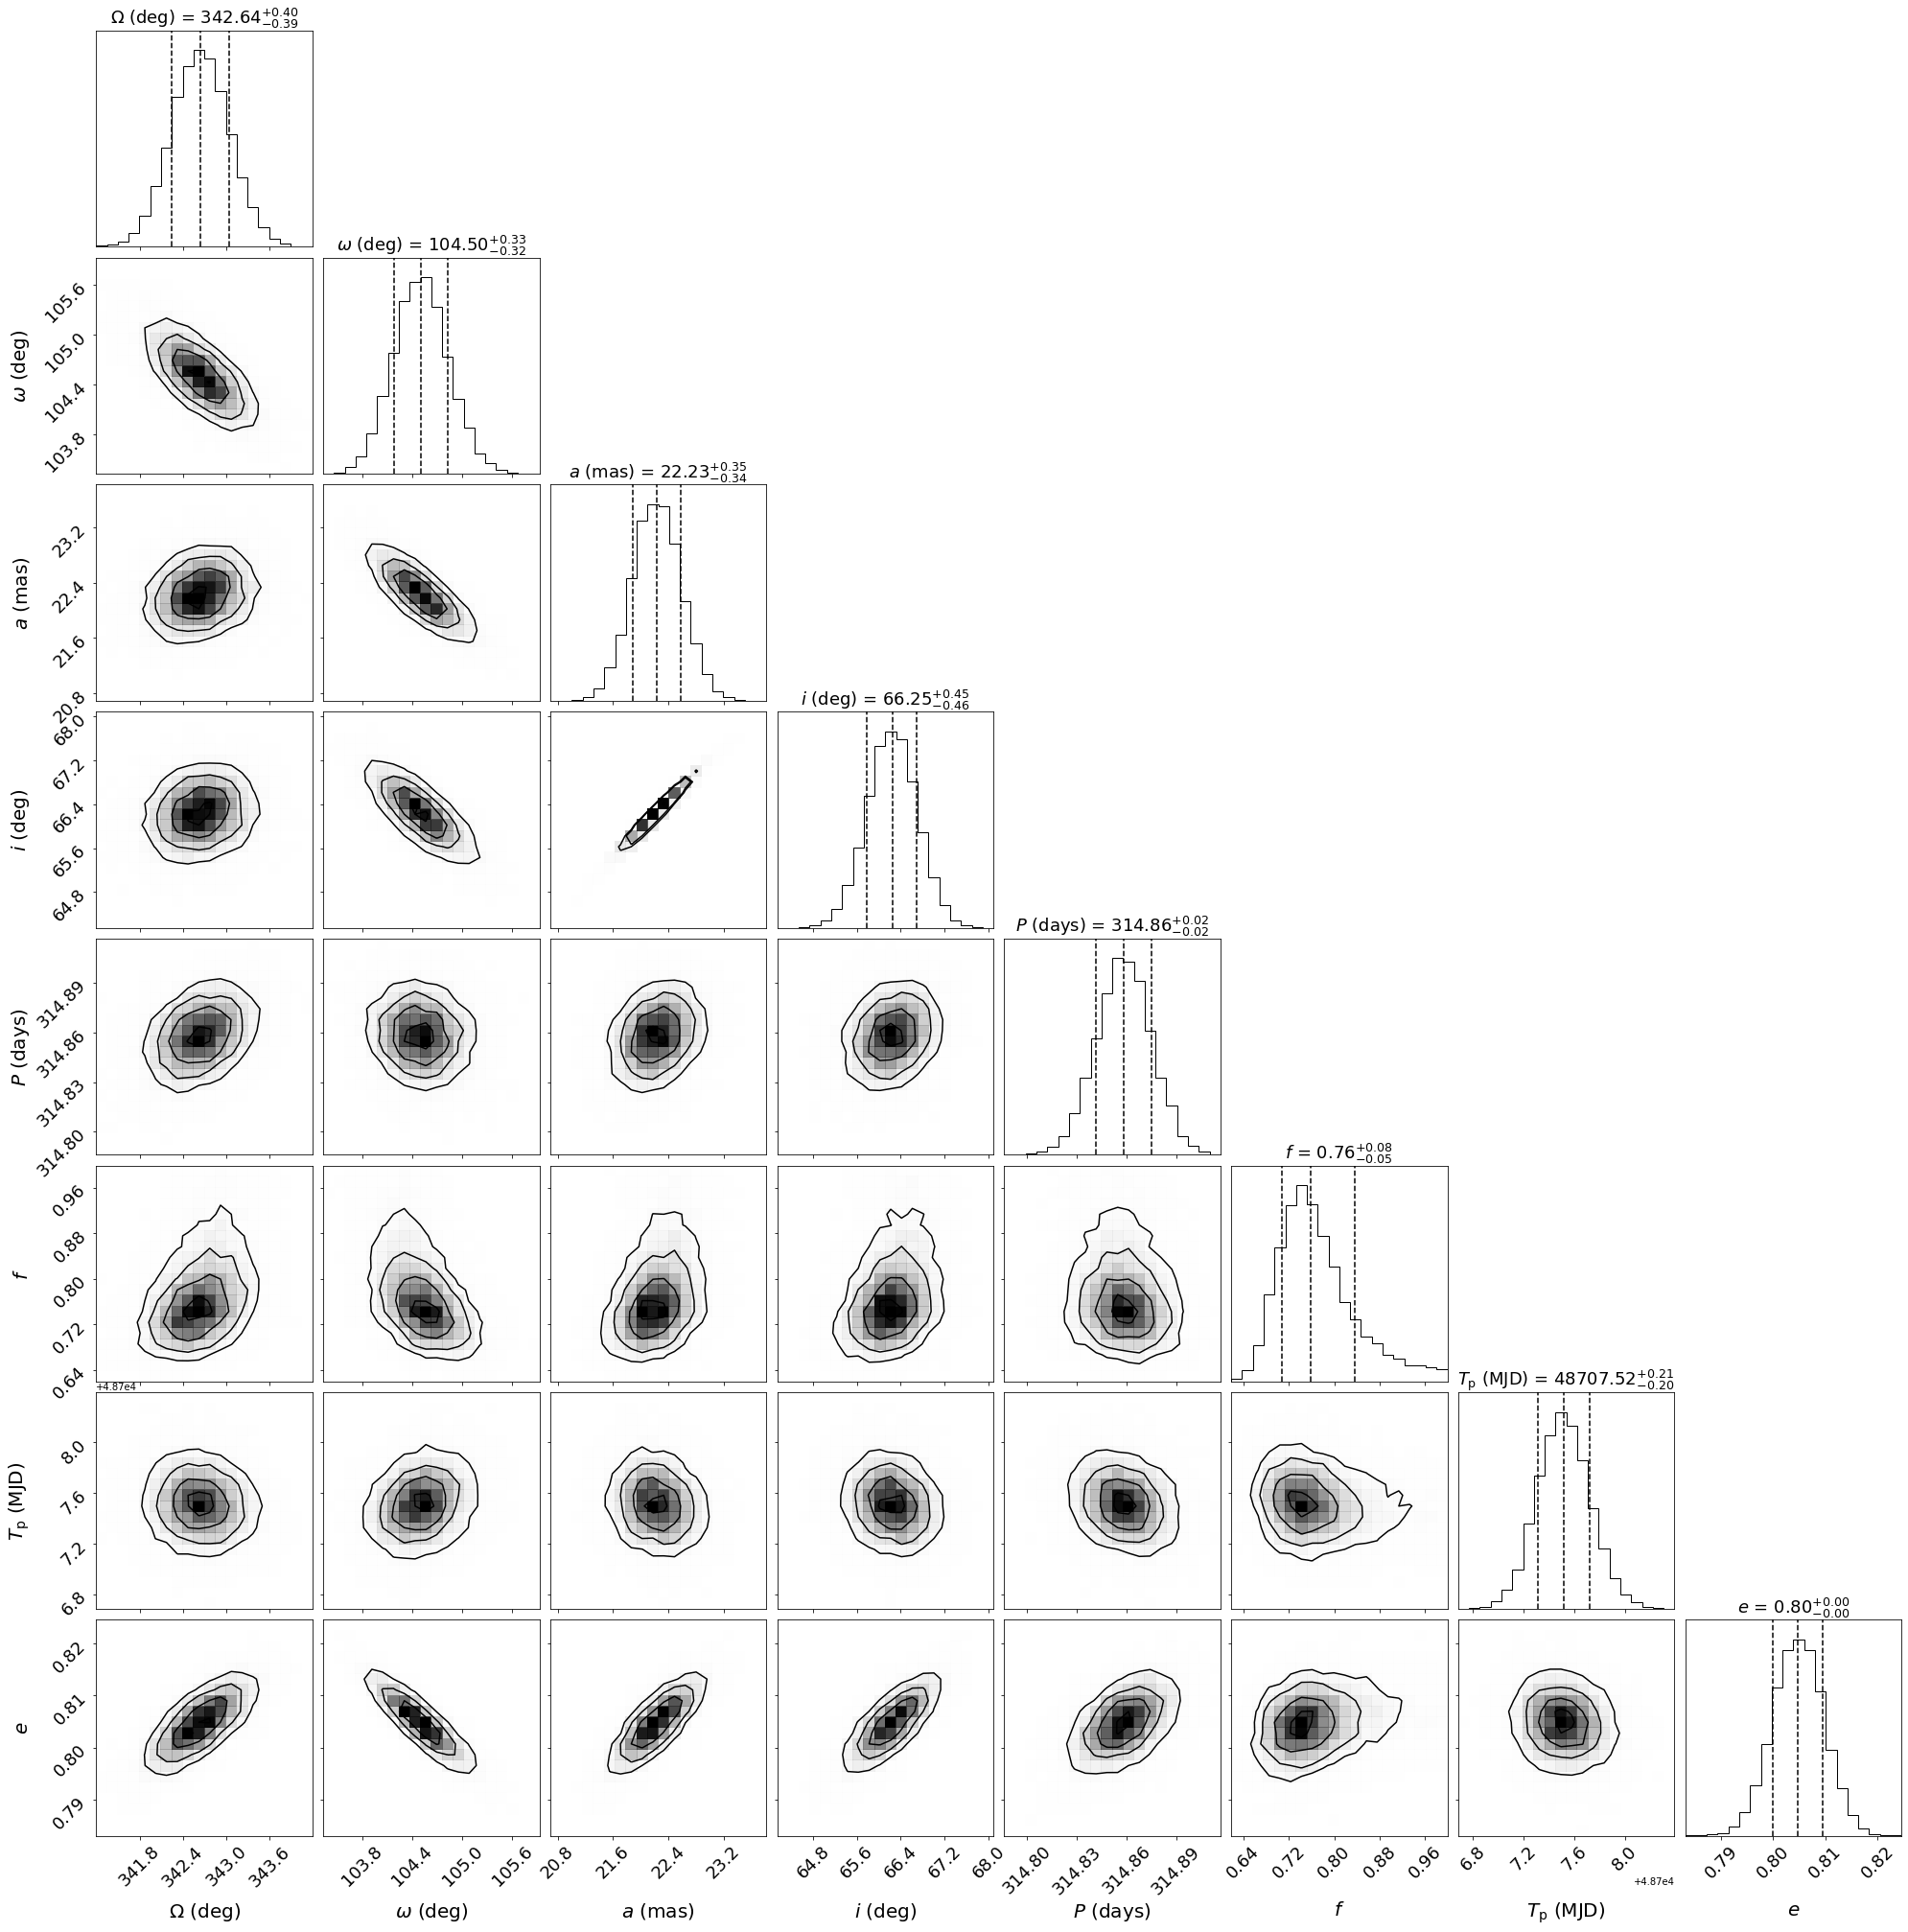

In [19]:
samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
samples["$\Omega$ (deg)"] = (trace["Omega"] / deg) % 360
samples["$\omega$ (deg)"] = (trace["omega"] / deg) % 360
samples["$a$ (mas)"] = trace["a_ang"] * 1000
samples["$i$ (deg)"] = (trace["incl"] / deg) % 180
samples["$P$ (days)"] = trace["P"]
samples["$f$"] = trace["f"]
samples["$T_\mathrm{p}$ (MJD)"] = trace["tp"] - 2400000.5
samples["$e$"] = trace["ecc"]

period, period_s = get_median_sigma(trace["P"])
print("Period (days): "+round(str(period), uncertainty=str(period_s), separation='$\pm$'))

tp, tp_s = get_median_sigma(trace["tp"]- 2400000.5)
print("Tp (MJD): "+round(str(tp), uncertainty=str(tp_s), separation='$\pm$'))

omega, omega_s = get_median_sigma((trace["omega"] * rad_2_deg) % 360)
print("omega (deg): "+round(str(omega), uncertainty=str(omega_s), separation='$\pm$'))

Omega, Omega_s = get_median_sigma((trace["Omega"] * rad_2_deg) % 360)
print("Omega (deg): "+round(str(Omega), uncertainty=str(Omega_s), separation='$\pm$'))

inc, inc_s = get_median_sigma((trace["incl"] * rad_2_deg) % 180)
print("i (deg): "+round(str(inc), uncertainty=str(inc_s), separation='$\pm$'))

aang, aang_s = get_median_sigma(trace["a_ang"]*1000)
print("a (mas): "+round(str(aang), uncertainty=str(aang_s), separation='$\pm$'))

ecc, ecc_s = get_median_sigma(trace["ecc"])
print("e: "+round(str(ecc), uncertainty=str(ecc_s), separation='$\pm$'))

K1, K1_s = get_median_sigma(trace["K1"])
print("K1 (km/s): "+round(str(K1), uncertainty=str(K1_s), separation='$\pm$'))

K2, K2_s = get_median_sigma(trace["K2"])
print("K2 (km/s): "+round(str(K2), uncertainty=str(K2_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma"])
print("gamma TO95 (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))

gamma2, gamma2_s = get_median_sigma(trace["gamma_ELO"])
print("gamma ELODIE (km/s): "+round(str(gamma2), uncertainty=str(gamma2_s), separation='$\pm$'))

gamma2, gamma2_s = get_median_sigma(trace["gamma_CTIO"])
print("gamma CTIO (km/s): "+round(str(gamma2), uncertainty=str(gamma2_s), separation='$\pm$'))

f, f_s = get_median_sigma(trace["f"])
print("f2/f1 : "+round(str(f), uncertainty=str(f_s), separation='$\pm$'))

del samples["Omega"]
figure = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 18}, label_kwargs=dict(fontsize=20), plot_datapoints=False)

figure.subplots_adjust(right=1.5,top=1.5)

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=18)
    
#plt.savefig('AaAb_corner.pdf')  

samples.to_csv('BaBb_posterior.csv', index=False)

figure.savefig('BaBb_corner.pdf',dpi=300,pad_inches=0.3,bbox_inches='tight')

M1 : 0.77$\pm$0.04
M2 : 0.62$\pm$0.02
a (AU) : 1.01$\pm$0.01
plx : 22.0$\pm$0.6
d (pc) : 46$\pm$1


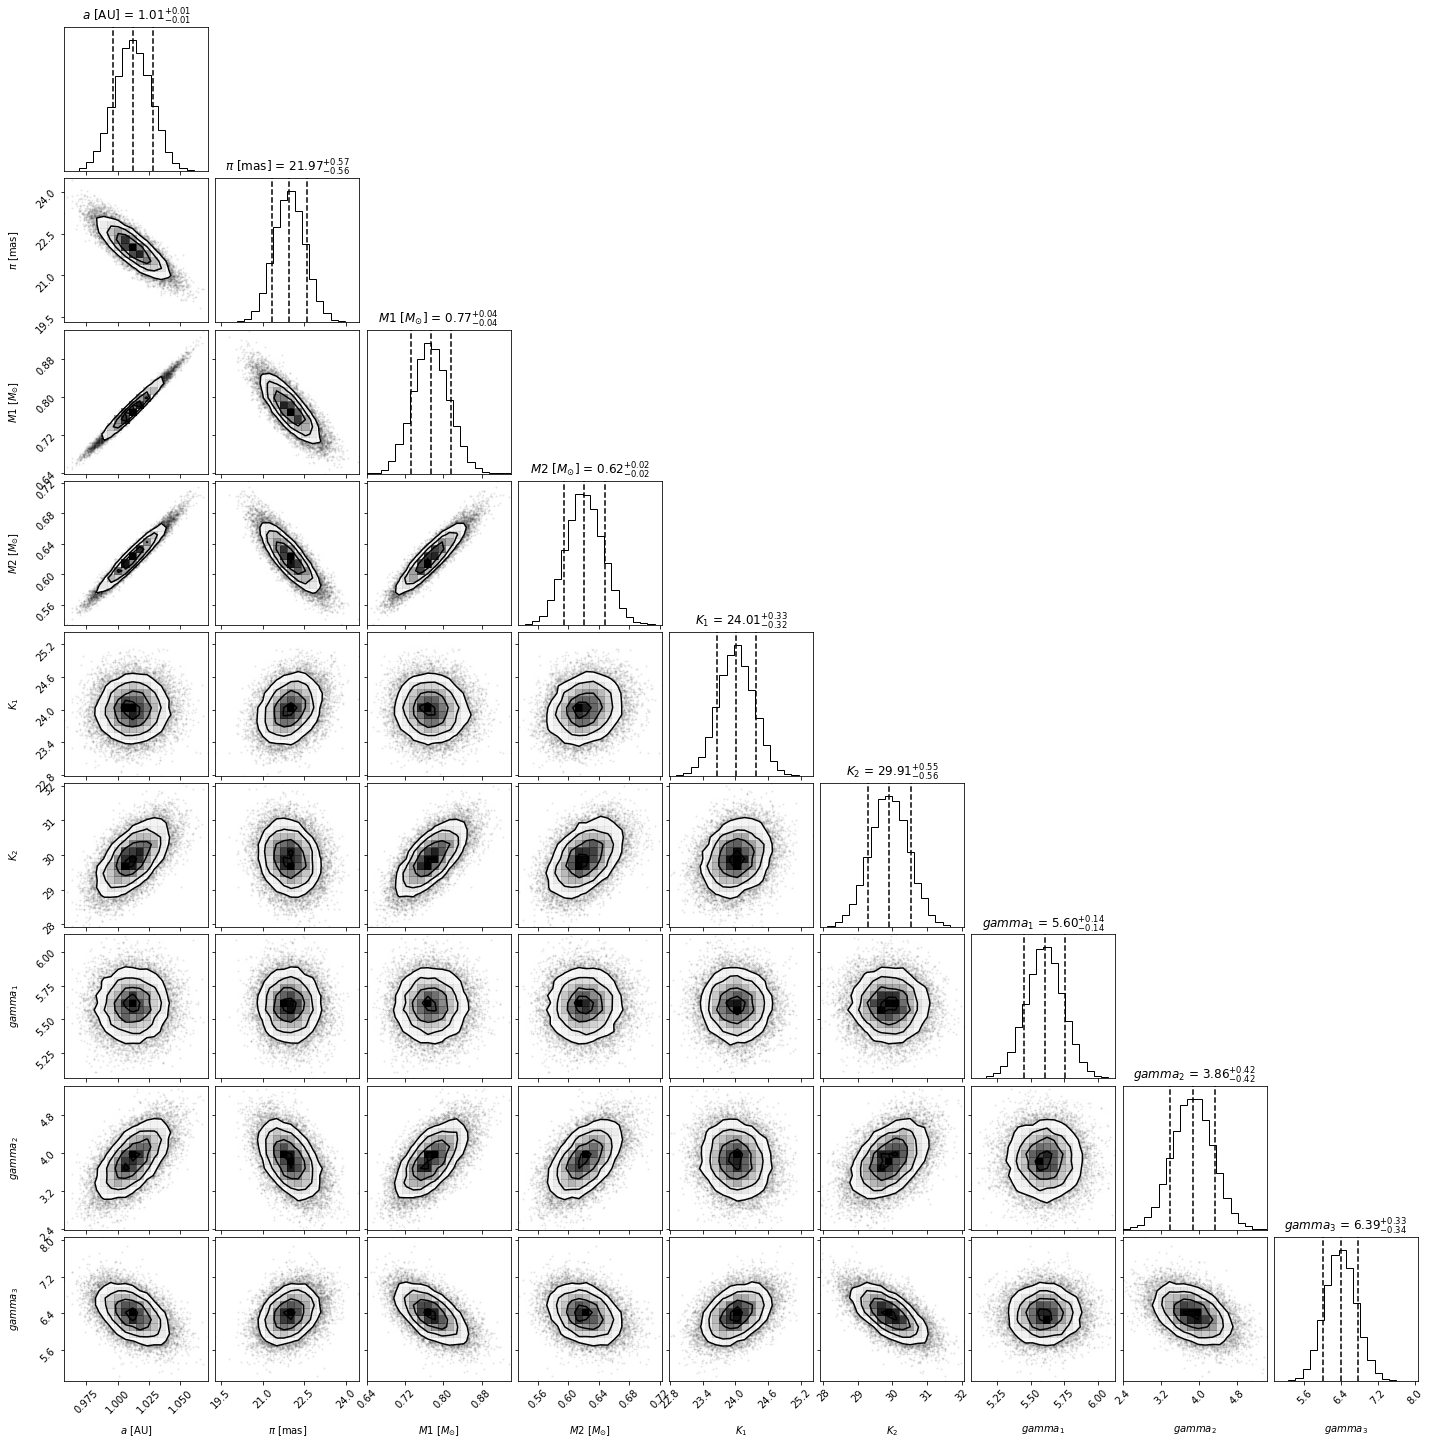

In [20]:
# Derived physical parameters

samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
samples["$a$ [AU]"] = trace["a_AU"]
samples["$\pi$ [mas]"] = trace["plx_save"]
#samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
#samples["$P$ [d]"] = trace["P"]
samples["$M1$ [$M_{\odot}$]"] = trace["M1_save"]
samples["$M2$ [$M_{\odot}$]"] = trace["M2_save"]
samples["$K_1$"] = trace["K1"]
samples["$K_2$"] = trace["K2"]
samples["$gamma_1$"] = trace["gamma"]
samples["$gamma_2$"] = trace["gamma_ELO"]
samples["$gamma_3$"] = trace["gamma_CTIO"]

#Save masses and plx for later comparison
samples_sol1 = samples[["$M1$ [$M_{\odot}$]","$M2$ [$M_{\odot}$]","$\pi$ [mas]"]]

# Formated for publication
M11, M11_s = get_median_sigma(trace["M1_save"])
print("M1 : "+round(str(M11), uncertainty=str(M11_s), separation='$\pm$'))

M22, M22_s = get_median_sigma(trace["M2_save"])
print("M2 : "+round(str(M22), uncertainty=str(M22_s), separation='$\pm$'))

aAU, aAU_s = get_median_sigma(trace["a_AU"])
print("a (AU) : "+round(str(aAU), uncertainty=str(aAU_s), separation='$\pm$'))

plx, plx_s = get_median_sigma(trace["plx_save"])
print("plx : "+round(str(plx), uncertainty=str(plx_s), separation='$\pm$'))



dist_pc, dist_pc_s = get_median_sigma(1/(trace["plx_save"]/1000))
print("d (pc) : "+round(str(dist_pc), uncertainty=str(dist_pc_s), separation='$\pm$'))

del samples["Omega"]
_ = corner.corner(samples,quantiles=[0.136, 0.5, 0.864], show_titles=True,
                  title_kwargs={"fontsize": 12})

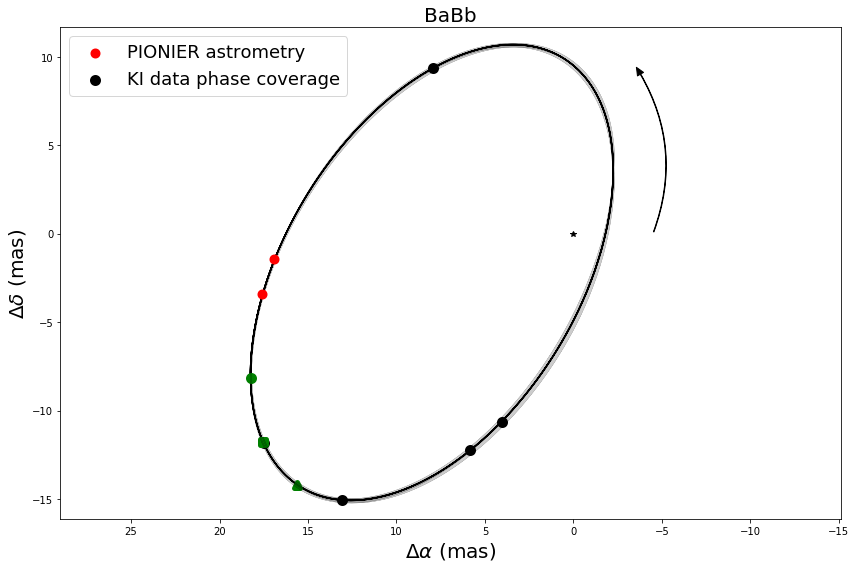

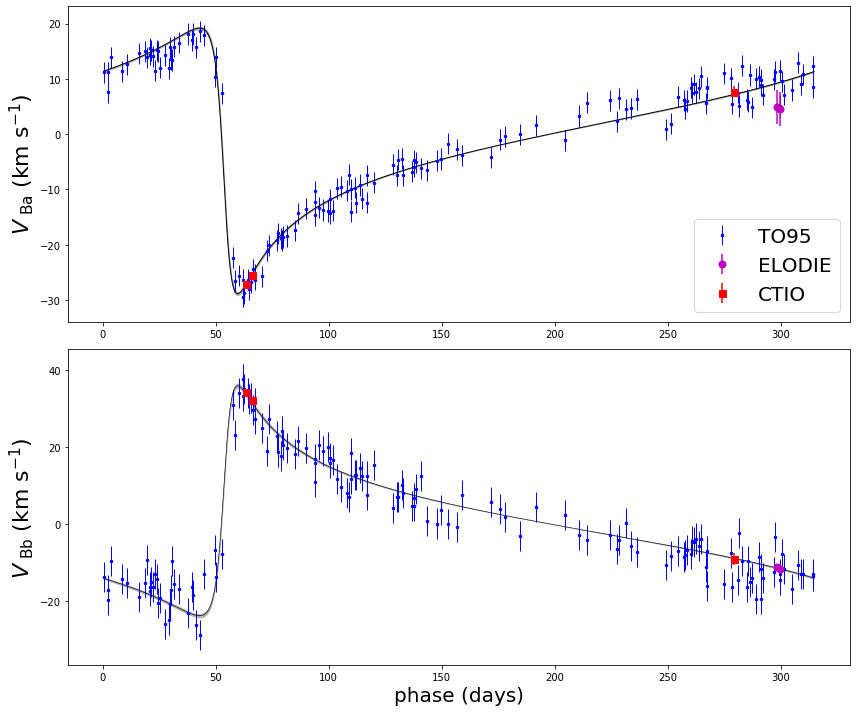

In [21]:
#ELO_errA = np.sqrt(rva_err_ELO**2 + np.exp(2 * np.median(trace["logjitterELODIE_A"])))
#ELO_errB = np.sqrt(rvb_err_ELO**2 + np.exp(2 * np.median(trace["logjitterELODIE_B"])))
#TO95_errA = np.sqrt(rva_err**2 + np.exp(2 * np.median(trace["logjitterTO95"])))
#TO95_errB = np.sqrt(rvb_err**2 + np.exp(2 * np.median(trace["logjitterTO95"])))
#CTIO_errA = np.sqrt(rva_err_CTIO**2 + np.exp(2 * np.median(trace["logjitterCTIO_A"])))
#CTIO_errB = np.sqrt(rvb_err_CTIO**2 + np.exp(2 * np.median(trace["logjitterCTIO_B"])))

import matplotlib.patches as patches

#print(np.median(ELO_errA))
#print(np.median(ELO_errB))
#print(np.median(CTIO_errA))
#print(np.median(CTIO_errB))
#print(np.median(TO95_errA))
#print(np.median(TO95_errB))


fig, axes = plt.subplots(1, 1, figsize=(12, 8))

period = np.percentile(trace["P"], [16, 50, 84], axis=0)
gamma = np.percentile(trace["gamma"], [16, 50, 84], axis = 0)
gamma2 = np.percentile(trace["gamma_ELO"], [16, 50, 84], axis = 0)
gamma3 = np.percentile(trace["gamma_CTIO"], [16, 50, 84], axis = 0)

ax = axes

qx = np.percentile(trace["x_save"], [16, 50, 84], axis=0)
qy = np.percentile(trace["y_save"], [16, 50, 84], axis=0)

#x_e = np.percentile(trace["x_enero"], [16, 50, 84], axis=0)
#y_e = np.percentile(trace["y_enero"], [16, 50, 84], axis=0)

#x_f = np.percentile(trace["x_febrero"], [16, 50, 84], axis=0)
#y_f = np.percentile(trace["y_febrero"], [16, 50, 84], axis=0)

#x_m = np.percentile(trace["x_marzo"], [16, 50, 84], axis=0)
#y_m = np.percentile(trace["y_marzo"], [16, 50, 84], axis=0)


ax.set_ylabel(r"$\Delta \delta$ (mas)", fontsize=20)
ax.scatter(x, y, marker='o', color='r', label='PIONIER astrometry', zorder=3, lw=4)
ax.plot(qx[1]*1000, qy[1]*1000, color = "k", lw=1.5, zorder = 0)

ax.scatter(np.median(trace["x_v2model_a03"])*1000, np.median(trace["y_v2model_a03"])*1000, marker='o',
           color = "k", label='KI data phase coverage', lw=5)
ax.scatter(np.median(trace["x_v2model_a04"])*1000, np.median(trace["y_v2model_a04"])*1000, marker='o', 
           color = "k", lw=5)
ax.scatter(np.median(trace["x_v2model_a05"])*1000, np.median(trace["y_v2model_a05"])*1000, marker='o', 
           color = "k", lw=5)
ax.scatter(np.median(trace["x_v2model_j04"])*1000, np.median(trace["y_v2model_j04"])*1000, marker='o', 
           color = "k", lw=5)
ax.scatter(np.median(trace["x_v2model_m03"])*1000, np.median(trace["y_v2model_m03"])*1000, marker='o', 
           color = "k", lw=5)

#P108
ax.scatter(np.median(trace["x_enero"])*1000, np.median(trace["y_enero"])*1000, marker='o', 
           color = "g", lw=5)
ax.scatter(np.median(trace["x_febrero"])*1000, np.median(trace["y_febrero"])*1000, marker='s', 
           color = "g", lw=5)
ax.scatter(np.median(trace["x_marzo"])*1000, np.median(trace["y_marzo"])*1000, marker='^', 
           color = "g", lw=5)



# 1 sigma orbit range
ax.fill_between(qx[0]*1000, qy[0]*1000, qy[2]*1000, color="k", lw =0.1, alpha = 0.2)
ax.fill_between(qx[2]*1000, qy[0]*1000, qy[2]*1000, color="k", lw=0.1, alpha = 0.2)
#ax.fill_between(qx[1]*1000, qy[0]*1000, qy[2]*1000, color="k", lw=0.1, alpha = 0.2)

style = "Simple, tail_width=0.5, head_width=7, head_length=8"
kw = dict(arrowstyle=style, color="k")

a3 = patches.FancyArrowPatch((-4.5, 0), (-3.5, 9.5),
                             connectionstyle="arc3,rad=.25", **kw)
plt.gca().add_patch(a3)

ax.legend(loc='upper left', prop={'size': 18})
ax.set_xlabel(r"$\Delta \alpha$ (mas)", fontsize=20)
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("BaBb", fontsize=20)

plt.tight_layout()

plt.savefig('BaBb_Orbit.pdf') 

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

 # Plot the folded model
x_fold = t_fine % period[1]
inds = np.argsort(x_fold)
va_model = trace["va_save"][:, inds]
vb_model = trace["vb_save"][:, inds]
va_model = np.percentile(va_model, [16, 50, 84], axis=0)
vb_model = np.percentile(vb_model, [16, 50, 84], axis=0)

ax = axes[0]
ax.set_ylabel("$V_{~\mathrm{Ba}}$ ($\mathrm{km~s^{-1}}$)", fontsize=22)
ax.fill_between(x_fold[inds], va_model[0], va_model[2], color="k", lw=0.1, alpha = 0.3)
ax.plot(x_fold[inds], va_model[1], color="k", lw=1.0)
ax.errorbar(t % period[1], rva - gamma[1], yerr=TO95_errA, fmt=".b", lw=1, ms=5, label='TO95')
ax.errorbar(t_ELO % period[1], rva_ELO - gamma2[1], yerr=ELO_errA, fmt="om",
            lw=1.5, ms = 7, label="ELODIE")
ax.errorbar(t_CTIO % period[1], rva_CTIO - gamma3[1], yerr=CTIO_errA, fmt="sr",
            lw=1.5, ms = 7, label="CTIO")
ax.legend(loc='lower right', prop={'size': 20})

ax = axes[1]
ax.fill_between(x_fold[inds], -vb_model[0], -vb_model[2], color="k", lw=0.1, alpha = 0.3)
ax.plot(x_fold[inds], -vb_model[1], color="k",lw=0.6)
ax.errorbar(t % period[1], rvb - gamma[1], yerr=TO95_errB, fmt=".b", lw=1, ms=5)
ax.errorbar(t_ELO % period[1], rvb_ELO - gamma2[1], yerr=ELO_errB, fmt="om",
            lw=1.5, ms = 7)
ax.errorbar(t_CTIO % period[1], rvb_CTIO - gamma3[1], yerr=CTIO_errB, fmt="sr",
            lw=1.5, ms = 7)


ax.set_ylabel("$V_{~\mathrm{Bb}}$ ($\mathrm{km~s^{-1}}$)", fontsize=22)
ax.set_xlabel("phase (days)", fontsize=20)

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

plt.tight_layout()

plt.savefig('BaBb_RVOrbit.pdf')  

In [22]:
print("O-C CTIO A")
print(np.percentile(trace["OC_CTIOa"], [16, 50, 84], axis = 0)[1])
print(CTIO_errA)
print("O-C CTIO B")
print(np.percentile(trace["OC_CTIOb"], [16, 50, 84], axis = 0)[1])
print(CTIO_errB)
print("O-C ELODIE A")
print(np.percentile(trace["OC_ELOa"], [16, 50, 84], axis = 0)[1])
print(ELO_errA)
print("O-C ELODIE B")
print(np.percentile(trace["OC_ELOb"], [16, 50, 84], axis = 0)[1])
print(ELO_errB)
print("O-C astrometry")
#print(np.percentile(trace["sigmaMaj_obs"], [16, 50, 84], axis = 0)[1])
print(astro_sigma_maj)

O-C CTIO A
[ 0.46700477  0.08456306 -0.29932341]
[1.00161257 0.2079128  0.2079128 ]
O-C CTIO B
[-0.20060842  0.26680576  0.90977158]
[1.50171939 0.50513476 0.50513476]
O-C ELODIE A
[-4.27880516 -4.85535798]
[3.04328043 3.04328043]
O-C ELODIE B
[ 0.24349301 -0.03093679]
[0.45839971 0.45839971]
O-C astrometry
[0.0183 0.0308]


In [56]:
t_CTIO-2400000.5

array([59323.1553, 59421.9871, 59424.9528])

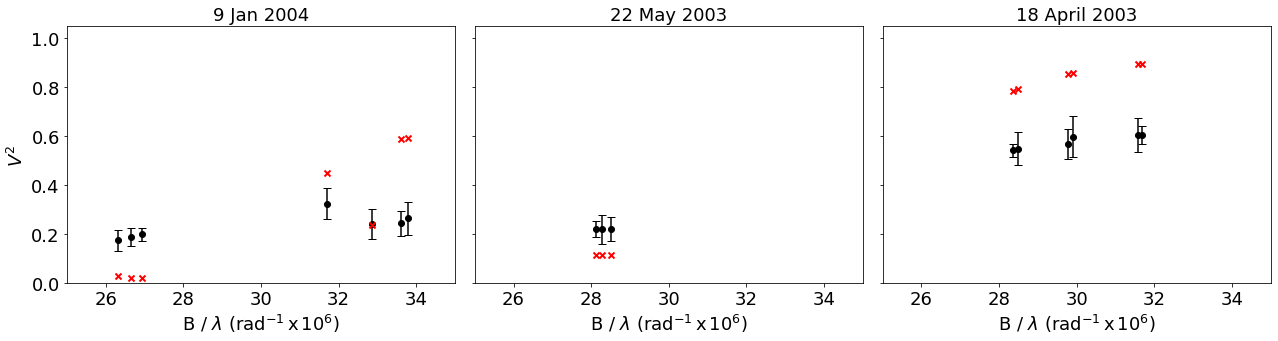

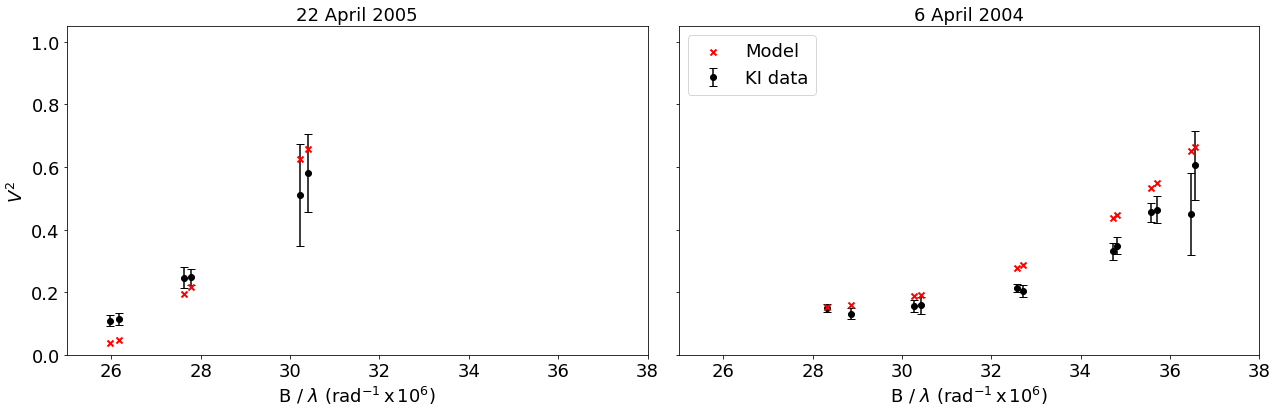

In [46]:
fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(18,5)

c =   1000 * np.pi/180/3600000.*1e6


x_v2model_a03 = np.median(trace['x_v2model_a03'])
y_v2model_a03 = np.median(trace['y_v2model_a03'])

x_v2model_a04 = np.median(trace['x_v2model_a04'])
y_v2model_a04 = np.median(trace['y_v2model_a04'])

x_v2model_a05 = np.median(trace['x_v2model_a05'])
y_v2model_a05 = np.median(trace['y_v2model_a05'])

x_v2model_j04 = np.median(trace['x_v2model_j04'])
y_v2model_j04 = np.median(trace['y_v2model_j04'])

x_v2model_m03 = np.median(trace['x_v2model_m03'])
y_v2model_m03 = np.median(trace['y_v2model_m03'])

B_a03 = np.sqrt(u_data_a03**2 + v_data_a03**2) / wavel_a03
B_a04 = np.sqrt(u_data_a04**2 + v_data_a04**2) / wavel_a04
B_a05 = np.sqrt(u_data_a05**2 + v_data_a05**2) / wavel_a05
B_m03 = np.sqrt(u_data_m03**2 + v_data_m03**2) / wavel_m03
B_j04 = np.sqrt(u_data_j04**2 + v_data_j04**2) / wavel_j04
        
model_v2_a03 = xy_to_V2(f,x_v2model_a03,y_v2model_a03, wavel_a03, u_data_a03, v_data_a03)
model_v2_a04 = xy_to_V2(f,x_v2model_a04,y_v2model_a04, wavel_a04, u_data_a04, v_data_a04)
model_v2_a05 = xy_to_V2(f,x_v2model_a05,y_v2model_a05, wavel_a05, u_data_a05, v_data_a05)
model_v2_m03 = xy_to_V2(f,x_v2model_m03,y_v2model_m03, wavel_m03, u_data_m03, v_data_m03)
model_v2_j04 = xy_to_V2(f,x_v2model_j04,y_v2model_j04, wavel_j04, u_data_j04, v_data_j04)

        

ax[2].set_title('18 April 2003', fontsize=18)
ax[2].errorbar(B_a03, vis2_a03, yerr= vis_err_a03, fmt='ok', capsize=4)
ax[2].set_xlabel('B / $\lambda$ ($\mathrm{rad^{-1}\,x\,10^6}$)', fontsize=18)
ax[2].scatter(B_a03,model_v2_a03, label='Model',marker='x', color='r', lw=2, zorder = 3)

ax[1].set_title('22 May 2003', fontsize=18)
ax[1].errorbar(B_m03, vis2_m03, yerr= vis_err_m03, fmt='ok', capsize=4)
ax[1].set_xlabel('B / $\lambda$ ($\mathrm{rad^{-1}\,x\,10^6}$)', fontsize=18)
ax[1].scatter(B_m03,model_v2_m03, label='Model',marker='x', color='r', lw=2, zorder = 3)

ax[0].set_title('9 Jan 2004', fontsize=18)
ax[0].errorbar(B_j04, vis2_j04, yerr= vis_err_j04, fmt='ok', capsize=4)
ax[0].set_xlabel('B / $\lambda$ ($\mathrm{rad^{-1}\,x\,10^6}$)', fontsize=18)
ax[0].set_ylabel('$V^{2}$', fontsize=18)
ax[0].scatter(B_j04,model_v2_j04, label='Model',marker='x', color='r', lw=2, zorder = 3)

plt.setp(ax,ylim=[0,1.05])
plt.setp(ax,xlim=[25,35])
#ax[2].legend(loc='upper left')

plt.tight_layout()
plt.savefig('V2_KI_A.pdf')

fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].set_title('22 April 2005', fontsize=18)
axs[0].errorbar(B_a05, vis2_a05, yerr= vis_err_a05, fmt='ok', capsize=4)
axs[0].set_xlabel('B / $\lambda$ ($\mathrm{rad^{-1}\,x\,10^6}$)', fontsize=18)
axs[0].set_ylabel('$V^{2}$', fontsize=18)
axs[0].scatter(B_a05,model_v2_a05, label='Model',marker='x', color='r', lw=2, zorder = 3)

axs[1].set_title('6 April 2004', fontsize=18)
axs[1].errorbar(B_a04, vis2_a04, yerr= vis_err_a04, fmt='ok', capsize=4, label = 'KI data')
axs[1].set_xlabel('B / $\lambda$ ($\mathrm{rad^{-1}\,x\,10^6}$)', fontsize=18)
axs[1].scatter(B_a04,model_v2_a04, label='Model',marker='x', color='r', lw=2, zorder = 3)

plt.setp(axs,ylim=[0,1.05])
plt.setp(axs,xlim=[25,38])
axs[1].legend(loc='upper left', prop={'size': 18})
fig.set_size_inches(18,6)

plt.rcParams.update({'font.size': 15})

plt.tight_layout()
plt.savefig('V2_KI_B.pdf')
plt.show()

In [ ]:
# Mutual inclination
n_sim=10000

deg2rad = np.pi/180
rad2deg = 180/np.pi 

# This work
i1 = np.random.normal(66.3,0.5,n_sim)
i2_a = np.random.normal(26,1,n_sim)
i2_b = np.random.normal(154,1,n_sim)
Omega1 = np.random.normal(342.7,0.4,n_sim)
Omega2 = np.random.normal(196,1,n_sim)

cos_angle_a = np.cos(i1*deg2rad)*np.cos(i2_a*deg2rad)+np.sin(i1*deg2rad)*np.sin(i2_a*deg2rad)*np.cos(Omega1*deg2rad-Omega2*deg2rad)
mutual_inc_new_a = np.arccos(cos_angle_a)*rad2deg

cos_angle_b = np.cos(i1*deg2rad)*np.cos(i2_b*deg2rad)+np.sin(i1*deg2rad)*np.sin(i2_b*deg2rad)*np.cos(Omega1*deg2rad-Omega2*deg2rad)
mutual_inc_new_b = np.arccos(cos_angle_b)*rad2deg


dist, dist_s = get_median_sigma(mutual_inc_new_a)

print("$\phi_{BaBb-Disk} (i=26)$: "+round(str(dist), uncertainty=str(dist_s), separation='$\pm$'))

dist, dist_s = get_median_sigma(mutual_inc_new_b)

print("$\phi_{BaBb-Disk} (i=154)$: "+round(str(dist), uncertainty=str(dist_s), separation='$\pm$'))

In [ ]:

n_sim=10000

deg2rad = np.pi/180
rad2deg = 180/np.pi 

# This work
i1 = np.random.normal(135.6,0.1,n_sim)
i2_a = np.random.normal(66.3,0.5,n_sim)

Omega1 = np.random.normal(170.2,0.1,n_sim)
Omega2 = np.random.normal(342.7,0.4,n_sim)

cos_angle_a = np.cos(i1*deg2rad)*np.cos(i2_a*deg2rad)+np.sin(i1*deg2rad)*np.sin(i2_a*deg2rad)*np.cos(Omega1*deg2rad-Omega2*deg2rad)
mutual_inc_new_a = np.arccos(cos_angle_a)*rad2deg


dist, dist_s = get_median_sigma(mutual_inc_new_a)

print("$\phi_{AaAb-BaBb}$: "+round(str(dist), uncertainty=str(dist_s), separation='$\pm$'))



In [ ]:
# Mutual inclination
n_sim=10000

deg2rad = np.pi/180
rad2deg = 180/np.pi 

# This work
i1 = np.random.normal(135.6,0.1,n_sim)
i2_a = np.random.normal(26,1,n_sim)
i2_b = np.random.normal(154,1,n_sim)
Omega1 = np.random.normal(170.2,0.1,n_sim)
Omega2 = np.random.normal(196,1,n_sim)

cos_angle_a = np.cos(i1*deg2rad)*np.cos(i2_a*deg2rad)+np.sin(i1*deg2rad)*np.sin(i2_a*deg2rad)*np.cos(Omega1*deg2rad-Omega2*deg2rad)
mutual_inc_new_a = np.arccos(cos_angle_a)*rad2deg

cos_angle_b = np.cos(i1*deg2rad)*np.cos(i2_b*deg2rad)+np.sin(i1*deg2rad)*np.sin(i2_b*deg2rad)*np.cos(Omega1*deg2rad-Omega2*deg2rad)
mutual_inc_new_b = np.arccos(cos_angle_b)*rad2deg


dist, dist_s = get_median_sigma(mutual_inc_new_a)

print("$\phi_{AaAb-Disk} (i=26)$: "+round(str(dist), uncertainty=str(dist_s), separation='$\pm$'))

dist, dist_s = get_median_sigma(mutual_inc_new_b)

print("$\phi_{AaAb-Disk} (i=154)$: "+round(str(dist), uncertainty=str(dist_s), separation='$\pm$'))

In [ ]:

n_sim=10000

deg2rad = np.pi/180
rad2deg = 180/np.pi 

# This work
i1 = np.random.normal(135.6,0.1,n_sim)
i2_a = np.random.normal(88.1,0.1,n_sim)

Omega1 = np.random.normal(170.2,0.1,n_sim)
Omega2 = np.random.normal(184.5,0.1,n_sim)

cos_angle_a = np.cos(i1*deg2rad)*np.cos(i2_a*deg2rad)+np.sin(i1*deg2rad)*np.sin(i2_a*deg2rad)*np.cos(Omega1*deg2rad-Omega2*deg2rad)
mutual_inc_new_a = np.arccos(cos_angle_a)*rad2deg


dist, dist_s = get_median_sigma(mutual_inc_new_a)

print("$\phi_{AaAb-Outer}$: "+round(str(dist), uncertainty=str(dist_s), separation='$\pm$'))

In [ ]:

n_sim=10000

deg2rad = np.pi/180
rad2deg = 180/np.pi 

# This work
i1 = np.random.normal(66.3,0.5,n_sim)
i2_a = np.random.normal(88.1,0.1,n_sim)

Omega1 = np.random.normal(342.7,0.4,n_sim)
Omega2 = np.random.normal(184.5,0.1,n_sim)

cos_angle_a = np.cos(i1*deg2rad)*np.cos(i2_a*deg2rad)+np.sin(i1*deg2rad)*np.sin(i2_a*deg2rad)*np.cos(Omega1*deg2rad-Omega2*deg2rad)
mutual_inc_new_a = np.arccos(cos_angle_a)*rad2deg


dist, dist_s = get_median_sigma(mutual_inc_new_a)

print("$\phi_{BaBb-Outer}$: "+round(str(dist), uncertainty=str(dist_s), separation='$\pm$'))

In [ ]:
# Mutual inclination
n_sim=10000

deg2rad = np.pi/180
rad2deg = 180/np.pi 

# This work
i1 = np.random.normal(88.1,0.1,n_sim)
i2_a = np.random.normal(26,1,n_sim)
i2_b = np.random.normal(154,1,n_sim)
Omega1 = np.random.normal(184.7,0.1,n_sim)
Omega2 = np.random.normal(196,1,n_sim)

cos_angle_a = np.cos(i1*deg2rad)*np.cos(i2_a*deg2rad)+np.sin(i1*deg2rad)*np.sin(i2_a*deg2rad)*np.cos(Omega1*deg2rad-Omega2*deg2rad)
mutual_inc_new_a = np.arccos(cos_angle_a)*rad2deg

cos_angle_b = np.cos(i1*deg2rad)*np.cos(i2_b*deg2rad)+np.sin(i1*deg2rad)*np.sin(i2_b*deg2rad)*np.cos(Omega1*deg2rad-Omega2*deg2rad)
mutual_inc_new_b = np.arccos(cos_angle_b)*rad2deg


dist, dist_s = get_median_sigma(mutual_inc_new_a)

print("$\phi_{AB-Disk} (i=26)$: "+round(str(dist), uncertainty=str(dist_s), separation='$\pm$'))

dist, dist_s = get_median_sigma(mutual_inc_new_b)

print("$\phi_{AB-Disk} (i=154)$: "+round(str(dist), uncertainty=str(dist_s), separation='$\pm$'))